# Barter System ([github](https://github.com/dcongtinh/barter-system))

#### Dao Cong Tinh - B1709632
#### Ta Dang Vinh Phuc - B1709618
#### Tran Minh Hoang - B1709594
#### Nguyen Minh Quang - B1709619


In [1]:
import pandas as pd 
import numpy as np

# read csv and assign columns
columns = ["personId", "productId"]
df = pd.read_csv("dataset/ratebeer/wish.csv", header=None)
df.columns = columns

number_of_row = len(df)
# get number of products
number_of_product = len(np.unique(df["productId"]))
# get number of person
number_of_person = len(np.unique(df["personId"]))
df = df.groupby("personId").aggregate(lambda x: list(np.unique(x)))

In [2]:
print("Number of row:", number_of_row)
print("Number of person:", number_of_person)
print("Number of product:", number_of_product)
# first samples
df.head()

Number of row: 118453
Number of person: 1953
Number of product: 21654


,productId
personId,
39,"[464, 562, 736, 739, 740, 1147, 1360, 1618, 21..."
63,"[36407, 36624, 53647]"
69,"[2442, 2491, 3401, 6924, 9193, 13730, 15017, 1..."
154,"[565, 1432, 3213, 7686, 10691, 14286, 15017, 1..."
181,"[4108, 7183, 7979, 10524, 11008, 14082, 19445,..."


In [3]:
# 'transactions' is now temporary variable
transactions = [row["productId"] for index, row in df.iterrows()]

In [4]:
from mlxtend.preprocessing import TransactionEncoder

transaction_encoder = TransactionEncoder()
wish_matrix = transaction_encoder.fit_transform(transactions).astype("int")
wish_df = pd.DataFrame(wish_matrix, columns=transaction_encoder.columns_)

# index is actually personId
wish_df.index = df.index 

In [5]:
wish_df.head()

,1,2,3,9,10,13,14,15,16,17,...,390987,391005,391163,391340,391802,392092,392165,392402,392478,393042
personId,,,,,,,,,,,,,,,,,,,,,
39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Stat that shows density distribution
### Number of known items - number of users

In [6]:
wish_count, freq = np.unique(wish_df.sum(axis=1), return_counts=True)

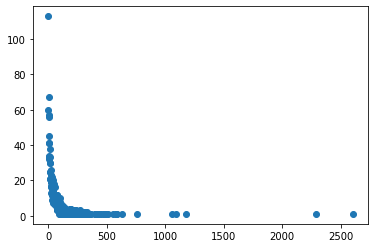

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(wish_count, freq)

# Erase useless samples which contains only 1 wish

In [8]:
new_df = wish_df.loc[wish_df.sum(axis=1) > 1] # keep user rows that have at least 2 products
print("Number of person having wish > 1:", len(new_df))
print("Training dataset shape:", new_df.shape)

Number of person having wish > 1: 1840
Training dataset shape: (1840, 21654)


In [9]:
person_to_products = df.loc[new_df.index]

In [10]:
person_to_products

,productId
personId,
39,"[464, 562, 736, 739, 740, 1147, 1360, 1618, 21..."
63,"[36407, 36624, 53647]"
69,"[2442, 2491, 3401, 6924, 9193, 13730, 15017, 1..."
154,"[565, 1432, 3213, 7686, 10691, 14286, 15017, 1..."
181,"[4108, 7183, 7979, 10524, 11008, 14082, 19445,..."
...,...
348417,"[6074, 6075, 6925, 7501, 7502, 11630, 12184, 1..."
350591,"[7502, 32329, 77319, 175070, 183623, 224747, 2..."
364565,"[127129, 143745, 198143, 240704, 251402, 300610]"


# Re-stat that shows density distribution
### Number of known items - number of users

In [11]:
wish_count, freq = np.unique(new_df.sum(axis=1), return_counts=True)

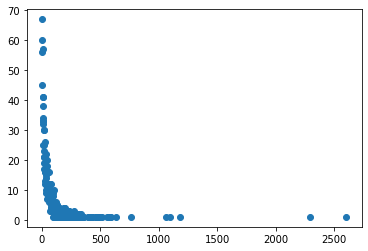

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(wish_count, freq)

# Transaction-based wish prediction using apriori

In [13]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(new_df, min_support=0.05)
rules = association_rules(frequent_itemsets, metric="lift")
# Something FAILED
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(776),(6441),0.111413,0.230978,0.051630,0.463415,2.006313,0.025896,1.433177
1,(6441),(776),0.230978,0.111413,0.051630,0.223529,2.006313,0.025896,1.144392
2,(5202),(1886),0.195109,0.129891,0.067935,0.348189,2.680621,0.042592,1.334910
3,(1886),(5202),0.129891,0.195109,0.067935,0.523013,2.680621,0.042592,1.687448
4,(6441),(2446),0.230978,0.129891,0.064130,0.277647,2.137534,0.034128,1.204548
...,...,...,...,...,...,...,...,...,...
173,(8766),(8324),0.113587,0.125000,0.053261,0.468900,3.751196,0.039062,1.647523
174,(15290),(14492),0.063587,0.107065,0.051630,0.811966,7.583843,0.044822,4.748790
175,(14492),(15290),0.107065,0.063587,0.051630,0.482234,7.583843,0.044822,1.808562
176,(15498),(14492),0.109783,0.107065,0.082065,0.747525,6.981957,0.070311,3.536722


In [14]:
len(rules)

178

In [15]:
print("Number of antecedents inferred:", len(np.unique(rules["antecedents"])))
print("Ratio of antecedents / well-known products:", len(np.unique(rules["antecedents"])) / number_of_product)

Number of antecedents inferred: 164
Ratio of antecedents / well-known products: 0.0075736584464764015


### Comment:
Generated rules is not that diversity to fit the whole dataset, we only got 178 rules whereas we got 1952 users in our dataset 

# Item-based prediction using cosine similarity
# Evaluation metrics: All but one
## With K-Folds Cross-Validation

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
import time

n_splits, mean_acc = 10, 0
kf = KFold(n_splits=n_splits, random_state=2021, shuffle=True)
idx, thresh = 0, 1e-3

start_time = time.time()
for train_index, test_index in kf.split(new_df):
    idx += 1
    X_train, X_test = new_df.iloc[train_index], new_df.iloc[test_index]
    # compute all sims between pairs of columns
    sims = cosine_similarity(X_train.T, X_train.T)

    # Make a new df cotaining similarity and headers
    sims_df = pd.DataFrame(sims)
    sims_df.columns = new_df.columns
    sims_df.index  = new_df.columns

    # precompute a set for quick query
    valid_product_set = set(sims_df.index)

    # evaluate all - but - one metrics:
    # steps:
    # 1: Assume that first valid one is unknown
    # 2: Calculate prediction value for it
    # 3: Verdict: +1 to score if pred > THRESHOLD
    score = 0

    for _, sample in X_test.iterrows():
        ids = person_to_products.loc[sample.name]["productId"]
        test_product_id = -1
        for id in ids:
            if id in valid_product_set:
                test_product_id = id # using all-but-one, need just one test product in valid_product_set
                break
        # we never get the case where all are invalid !!!
        # assume that we didn't know that product is chosen

        # sum(user_sample[i] * sim(test_product_id, i))
        dot_prod = np.dot(sample, sims_df.loc[test_product_id]) - 1 # dot_prod-1: subtract itself (test_product_id)
        # sum(sim(test_product_id, i))
        sum_sims = sims_df.loc[test_product_id].sum() - 1 # sum_sims-1: subtract itself (test_product_id)
        pred = dot_prod / sum_sims # cosine
        score += (pred > thresh) # 1 if pred > thresh else 0
        
    acc = score / len(X_test) * 100
    print("%4d-Accuracy: %.2f%%" % (idx, acc))
    mean_acc += acc

print("Mean Accuracy: %.2f%%" % (mean_acc/n_splits))
print("Training time:", time.time() - start_time, "seconds")

   1-Accuracy: 91.30%
   2-Accuracy: 88.59%
   3-Accuracy: 89.13%
   4-Accuracy: 88.59%
   5-Accuracy: 89.67%
   6-Accuracy: 91.30%
   7-Accuracy: 90.76%
   8-Accuracy: 87.50%
   9-Accuracy: 87.50%
  10-Accuracy: 86.41%
Mean Accuracy: 89.08%
Training time: 145.72275304794312 seconds


# Prediction

In [17]:
sims = cosine_similarity(new_df.T, new_df.T)

# Make a new df cotaining similarity and headers
sims_df = pd.DataFrame(sims)
sims_df.columns = new_df.columns
sims_df.index  = new_df.columns

In [18]:
def give_recommendations(user_sample, return_num):
    """
    user_sample: product's ids that user need
    return_num: the top number of recommendations sorted by confidence prediction
    """
    result = []
    sample = [0] * len(new_df.columns)
    user_product_set = set(user_sample)
    for product_id in user_sample:
        sample[product_id] = 1    
    for test_product_id in new_df.columns:
        # skip known product
        if test_product_id in user_product_set:
            continue
        # sum(user_sample[i] * sim(test_product_id, i))
        dot_prod = np.dot(sample, sims_df.loc[test_product_id]) - 1
        # sum(sim(test_product_id, i))
        sum_sims = sims_df.loc[test_product_id].sum() - 1
        pred = dot_prod / sum_sims
        if pred > thresh:
            result.append((pred, test_product_id))
            
    result = np.array(sorted(result)[::-1][:return_num])
    return result[:, 1].astype(int)

import time
print("Start looking for recommendations ...")

marker = time.time()
recommendations = give_recommendations([1, 3, 9], 10)
print("Looking done in", time.time()-marker, " seconds")

print("Recommended products (id):", recommendations)

Start looking for recommendations ...
Looking done in 62.18922281265259  seconds
Recommended products (id): [297755 284103 131601 129901  64757  26171  16735   6114 334067 331741]
